## [Juan Diego]

## Hypothesis

¿Will the raw audio files 1D have the same performance for noise cleaning and classifer compared to melSpectrogram 2d audio files?

#Set up environment

In [1]:
import io
import torch
from torchvision import models, transforms, datasets
import torch.utils.data as data
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F

import os
import os.path
import pickle
import hashlib
import librosa
from scipy.io import wavfile


import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import IPython
import soundfile

#example https://github.com/GRAAL-Research/poutyne/blob/master/examples/mnist.ipynb
!pip install poutyne


import torch.nn as nn
import torch.optim as optim
from poutyne.framework import Model
from torchsummary import summary
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")


     |████████████████████████████████| 143kB 5.7MB/s 


## Download database and uncompress it

and also pretrained models to make the practice session faster

In [2]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1HR28jRFwrveq5zxjkzri61jm9F4-M7p7"
!tar -zxf speech_commands_v0.01_with_splits.tar.gz

usePretrainedModels = True
!gdown "https://drive.google.com/uc?id=1-BlKCm0J6RUCQrliCLtUP8u2zkagltAK"
!tar -zxf models.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1HR28jRFwrveq5zxjkzri61jm9F4-M7p7
To: /content/speech_commands_v0.01_with_splits.tar.gz
1.49GB [00:29, 50.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-BlKCm0J6RUCQrliCLtUP8u2zkagltAK
To: /content/models.tar.gz
22.2MB [00:00, 43.1MB/s]


# Define functions to compute the MelSpectrogram features within pytorch


In [3]:
#Helper Functions borrowed from torchaudio https://github.com/pytorch/audio/blob/master/torchaudio/transforms.py

class PadTrim(object):
    """Pad/Trim a 1d-Tensor (Signal or Labels)
    Args:
        tensor (Tensor): Tensor of audio of size (n x c) or (c x n)
        max_len (int): Length to which the tensor will be padded
        channels_first (bool): Pad for channels first tensors.  Default: `True`
    """

    def __init__(self, max_len, fill_value=0, channels_first=True):
        self.max_len = max_len
        self.fill_value = fill_value
        self.len_dim, self.ch_dim = int(channels_first), int(not channels_first)

    def __call__(self, tensor):
        """
        Returns:
            Tensor: (c x n) or (n x c)
        """
        assert tensor.size(self.ch_dim) < 128, \
            "Too many channels ({}) detected, see channels_first param.".format(tensor.size(self.ch_dim))
        if self.max_len > tensor.size(self.len_dim):
            padding = [self.max_len - tensor.size(self.len_dim)
                       if (i % 2 == 1) and (i // 2 != self.len_dim)
                       else 0
                       for i in range(4)]
            with torch.no_grad():
                tensor = torch.nn.functional.pad(tensor, padding, "constant", self.fill_value)
        elif self.max_len < tensor.size(self.len_dim):
            tensor = tensor.narrow(self.len_dim, 0, self.max_len)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(max_len={0})'.format(self.max_len)




class MelScale(object):
    """This turns a normal STFT into a mel frequency STFT, using a conversion
       matrix.  This uses triangular filter banks.
    Args:
        n_mels (int): number of mel bins
        sr (int): sample rate of audio signal
        f_max (float, optional): maximum frequency. default: `sr` // 2
        f_min (float): minimum frequency. default: 0
        n_stft (int, optional): number of filter banks from stft. Calculated from first input
            if `None` is given.  See `n_fft` in `Spectrogram`.
    """
    def __init__(self, n_mels=128, sr=16000, f_max=None, f_min=0., n_stft=None):
        self.n_mels = n_mels
        self.sr = sr
        self.f_max = f_max if f_max is not None else sr // 2
        self.f_min = f_min
        self.fb = self._create_fb_matrix(n_stft) if n_stft is not None else n_stft

    def __call__(self, spec_f):
        if self.fb is None:
            self.fb = self._create_fb_matrix(spec_f.size(2)).to(spec_f.device)
        else:
            # need to ensure same device for dot product
            self.fb = self.fb.to(spec_f.device)
        spec_m = torch.matmul(spec_f, self.fb)  # (c, l, n_fft) dot (n_fft, n_mels) -> (c, l, n_mels)
        return spec_m

    def _create_fb_matrix(self, n_stft):
        """ Create a frequency bin conversion matrix.
        Args:
            n_stft (int): number of filter banks from spectrogram
        """

        # get stft freq bins
        stft_freqs = torch.linspace(self.f_min, self.f_max, n_stft)
        # calculate mel freq bins
        m_min = 0. if self.f_min == 0 else self._hertz_to_mel(self.f_min)
        m_max = self._hertz_to_mel(self.f_max)
        m_pts = torch.linspace(m_min, m_max, self.n_mels + 2)
        f_pts = self._mel_to_hertz(m_pts)
        # calculate the difference between each mel point and each stft freq point in hertz
        f_diff = f_pts[1:] - f_pts[:-1]  # (n_mels + 1)
        slopes = f_pts.unsqueeze(0) - stft_freqs.unsqueeze(1)  # (n_stft, n_mels + 2)
        # create overlapping triangles
        z = torch.tensor(0.)
        down_slopes = (-1. * slopes[:, :-2]) / f_diff[:-1]  # (n_stft, n_mels)
        up_slopes = slopes[:, 2:] / f_diff[1:]  # (n_stft, n_mels)
        fb = torch.max(z, torch.min(down_slopes, up_slopes))
        return fb

    def _hertz_to_mel(self, f):
        return 2595. * torch.log10(torch.tensor(1.) + (f / 700.))

    def _mel_to_hertz(self, mel):
        return 700. * (10**(mel / 2595.) - 1.)
      
class MelSpectrogram(nn.Module):
    def __init__(self, n_mels = 40, sfr=16000):
        super().__init__()
        
        self.sfr = sfr
        self.window_stride=0.01
        self.window_size=0.02
        self.n_fft=512
        self.n_mels=n_mels
        
        self.win_length = int(self.sfr * self.window_size)
        self.hop_length = int(self.sfr * self.window_stride)
        self.lowfreq = 20
        self.highfreq = self.sfr/2 - 400
        self.window = torch.hamming_window(self.win_length).cuda()
        
        self.mel = MelScale(n_mels=self.n_mels, sr=self.sfr, f_max=self.highfreq, f_min=self.lowfreq)
        self.norm = nn.InstanceNorm2d(1)

    def __call__(self, x):
        if self.window.device != x.device:
            self.window = self.window.to(x.device)
        x = x.squeeze(1)
        spec_f = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, 
                    win_length=self.win_length, 
                    window=self.window,
                    center=True,
                    normalized=False, onesided=True,
                    pad_mode='reflect'
                   )
        spec_f = spec_f.pow(2).sum(-1)
        x = self.mel(spec_f.transpose(1,2)).transpose(1,2)
        x = torch.log(x+0.0001)
        x = x.unsqueeze(1)
        #x = self.norm(x)
        return x
      
      
    def plot_sample(self, fbank, index):
        librosa.display.specshow(fbank[index,:,:,:].view(self.n_mels,-1).numpy(),
                          y_axis='mel', x_axis='time',sr=self.sfr, fmax=self.highfreq, hop_length=self.hop_length)
        plt.title('Mel spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()

##Explore Data

Sample shape torch.Size([1, 15900])
Sample shape after padtrim torch.Size([1, 16000])
Mel matrix shape torch.Size([257, 40])
fbank shape torch.Size([1, 1, 40, 101])


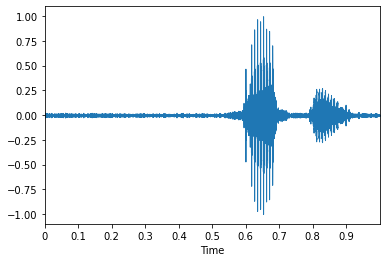

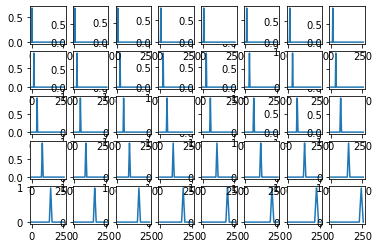

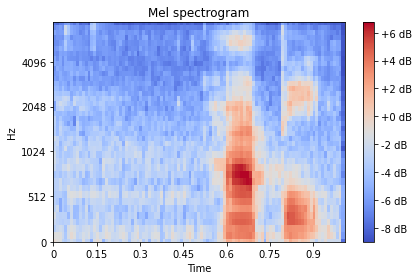

In [4]:
#audio, sfr = librosa.load("gcommands/audio/happy/6d0ad764_nohash_3.wav", sr=16000)
sfs, audio = wavfile.read("gcommands/audio/happy/9dcfba4b_nohash_0.wav")
audio = audio / 2**15
audio -= audio.mean()
max_val = audio.max()
audio /= max_val + 0.001
plt.figure()
librosa.display.waveplot(audio, sr=16000)
IPython.display.display(IPython.display.Audio('gcommands/audio/happy/9dcfba4b_nohash_0.wav'))



sample = torch.FloatTensor(audio[:-100])
sample = sample.view(1,-1)
print("Sample shape", sample.shape)
test_PadTrim = PadTrim(max_len=16000)
sample = test_PadTrim(sample)
print("Sample shape after padtrim", sample.shape)
test_MelSpectrogram = MelSpectrogram(n_mels=40)

fbank = test_MelSpectrogram(sample)
print("Mel matrix shape" , test_MelSpectrogram.mel.fb.shape)
plt.figure()
for i in range(5):
    for j in range(8):
        plt.subplot(5, 8, i+j*5+1)
        plt.plot(test_MelSpectrogram.mel.fb[:,i+j*5].numpy())



plt.figure()
print("fbank shape", fbank.shape)


test_MelSpectrogram.plot_sample(fbank, index=0)



#AudioReader for wavefiles

This reader provides data in the format (X = noisy_raw_audio, Y = (clean_raw_audio, target_class))

**add_silence_class** parameter: includes random samples from background noise to the dataset in the sample proportion as the "yes" class

**add_noise** parameter: If True it add random background noise to raw audio on the fly


In [5]:
class AudioReader(data.Dataset):
  
    def __init__(self, list_path, transform=PadTrim(16000), add_silence_class=False, add_noise=False):
        
        self.list_path = list_path
        self.database_path = os.path.dirname(list_path) + '/audio/'
        self.add_noise = add_noise
        self.add_silence_class = add_silence_class
        self.transform = transform

        self.target_class = {}
        self.target_class_idx_to_name = {}
        self.target_class_names = ['unknown','silence', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
        for i, name in enumerate(self.target_class_names):
            self.target_class[name] = i
            self.target_class_idx_to_name[i] = name
        self.audio_class = {}
        self.audio_speaker = {}
        self.audios = []
                 
        self.read_list_data()
                 
        self.speaker_ids = {}
        for i, spk_id in enumerate(self.audio_speaker.values()):
            self.speaker_ids[spk_id] = i
        
        
        self.num_silence = 0
        
        if self.add_noise or self.add_silence_class:
            self.background_noises_names = []
            self.background_noises = []
            for f in os.listdir(self.database_path + '/_background_noise_/'):
                if f.endswith(".wav"):
                    self.background_noises_names.append('_background_noise_/' + f)
                    print(self.background_noises_names[-1])
                    self.background_noises.append( self.load_audio(self.background_noises_names[-1]))

                    
        if self.add_silence_class:  #Adding the same amount of samples as the "yes" class
            self.num_silence = sum(1 for i in self.audio_class.values() if i == 'yes')
            
        self.seeded = False
        
        
    
    def read_list_data(self):
        with open(self.list_path, 'r') as stream:
            for line in stream:
                file_path = line.strip()
                file_class, file_name = file_path.split('/')
                identity = file_name.split('_')[0]
                self.audio_class[file_path] = file_class
                self.audio_speaker[file_path] = identity
                self.audios.append(file_path)
                
        
    def __len__(self):
        return len(self.audio_class) + self.num_silence


    def __getitem__(self, index):
        
        if not self.seeded:
            self.seeded = True
            np.random.seed(index)
            
        if index >= len(self.audios):
            spk_id=-1
            length = 16000
            audio = self.get_silence_chunk(length)
            target_id = self.target_class['silence']
            audio_id = 'random_silence/randomchunk.wav' 
        else:
          
            audio_id = self.audios[index]
            audio = self.load_audio(audio_id)
      
            spk_id = self.speaker_ids[self.audio_speaker[audio_id]]
            target = self.audio_class[audio_id]
      
            if target not in self.target_class_names:
                target = 'unknown'
            target_id = self.target_class[target]
            
        audio -= audio.mean()
        max_val = np.abs(audio[np.argpartition(np.abs(audio),-10)[-10:]]).mean()
        audio /= max_val + 0.001    
            
        sample = torch.FloatTensor(audio)
        if self.add_noise:
            alpha = np.random.uniform(low=0.75, high=0.98)
            beta = 1.0 - alpha
            silence_chunk = self.get_silence_chunk(len(audio))
            max_val = np.abs(silence_chunk[np.argpartition(np.abs(silence_chunk),-10)[-10:]]).mean()
            silence_chunk /= max_val + 0.001    
            sample_noise = torch.FloatTensor(audio * alpha + beta * silence_chunk)
        
        if self.transform is not None:
            sample = sample.view(1,-1)
            sample = self.transform(sample)
            if self.add_noise:
                sample_noise = sample_noise.view(1,-1)
                sample_noise = self.transform(sample_noise)
              
            
        if self.add_noise:
            return [sample_noise, [sample, target_id]]
        else:
            return [sample, [sample, target_id]]
        
    def load_audio(self, audio_name):
        
        audio_path = self.database_path + audio_name
        fs, audio = wavfile.read(audio_path)
        audio = audio / 2**15
        #audio, fs = librosa.load(audio_path)

        return audio
                 
    
    
    def get_silence_chunk(self, length):
        i = np.random.randint(0, len(self.background_noises))
        silence = self.background_noises[i]
        max_start = silence.shape[0] - length -1
        random_start = np.random.randint(0, max_start)
        #print("Starting at", random_start )
        chunk = silence[random_start:(random_start + length)]
        return chunk
      
    def get_class_weights(self):
        class_ids = []
        for target in self.audio_class.values():
            if target not in self.target_class_names:
                target = 'unknown'
            target_id = self.target_class[target]
            class_ids.append(target_id)
        for jj in range(self.num_silence):
            class_ids.append(self.target_class['silence'])
        class_ids.append(self.target_class['unknown'])
        from sklearn.utils import class_weight
        #print(np.unique(class_ids))
        class_weight = class_weight.compute_class_weight('balanced', np.unique(class_ids),class_ids)
        class_weight = torch.from_numpy(class_weight).float()
        return class_weight
      
    def get_n_classes(self):
        return len(self.target_class_names)
     
    


We need readers without adding background noise and adding background noise
We also have noisy_alldata_loader which reads from train+valid+test and will be used for unsupervised training

In [6]:
train_loader = data.DataLoader(
                    AudioReader('gcommands/training_list.txt',add_silence_class=True, 
                                add_noise=False), 
                        batch_size=50, shuffle=True, num_workers=2,
                    )

valid_loader = data.DataLoader(
                    AudioReader('gcommands/validation_list.txt'), 
                        batch_size=50, shuffle=False, num_workers=2, 
                    )

test_loader = data.DataLoader(
                    AudioReader('gcommands/testing_list.txt'), 
                        batch_size=50, shuffle=False, num_workers=2, 
                    )

noisy_train_loader = data.DataLoader(
                    AudioReader('gcommands/training_list.txt',add_silence_class=True, 
                                add_noise=True), 
                        batch_size=50, shuffle=True, num_workers=2,
                    )

noisy_valid_loader = data.DataLoader(
                    AudioReader('gcommands/validation_list.txt', add_noise=True), 
                        batch_size=50, shuffle=False, num_workers=2,
                    )

noisy_test_loader = data.DataLoader(
                    AudioReader('gcommands/testing_list.txt', add_noise=True), 
                        batch_size=50, shuffle=False, num_workers=2,
                    )

noisy_alldata_loader = data.DataLoader(
                    AudioReader('gcommands/total_list.txt', add_noise=True), 
                        batch_size=50, shuffle=True, num_workers=2,
                    )

_background_noise_/running_tap.wav
_background_noise_/pink_noise.wav
_background_noise_/doing_the_dishes.wav
_background_noise_/exercise_bike.wav
_background_noise_/white_noise.wav
_background_noise_/dude_miaowing.wav
_background_noise_/running_tap.wav
_background_noise_/pink_noise.wav
_background_noise_/doing_the_dishes.wav
_background_noise_/exercise_bike.wav
_background_noise_/white_noise.wav
_background_noise_/dude_miaowing.wav
_background_noise_/running_tap.wav
_background_noise_/pink_noise.wav
_background_noise_/doing_the_dishes.wav
_background_noise_/exercise_bike.wav
_background_noise_/white_noise.wav
_background_noise_/dude_miaowing.wav
_background_noise_/running_tap.wav
_background_noise_/pink_noise.wav
_background_noise_/doing_the_dishes.wav
_background_noise_/exercise_bike.wav
_background_noise_/white_noise.wav
_background_noise_/dude_miaowing.wav
_background_noise_/running_tap.wav
_background_noise_/pink_noise.wav
_background_noise_/doing_the_dishes.wav
_background_noise_/

 ## Data exploration
 
 What does the data from AudioLoader look like?
 
 
Can you see the differences in the MelSpectrogram of clean and noisy audio?

In [7]:
# [sample_noise, [sample, target_id]] being: noisy audio, [clean audio, class]
for batch in noisy_train_loader:
    break
noisy_audio, [clean_audio, target_class] = batch
print(batch[0].shape, "--- [batch, channel (raw audio), samples for 1 second]") # noisy audio
print(batch[1][0].shape, "--- [batch, channel (raw audio), samples for 1 second]") # clean auido
print(batch[1][1].shape) # target

torch.Size([50, 1, 16000]) --- [batch, channel (raw audio), samples for 1 second]
torch.Size([50, 1, 16000]) --- [batch, channel (raw audio), samples for 1 second]
torch.Size([50])


Noisy audio shape torch.Size([50, 1, 16000])
Clean audio shape torch.Size([50, 1, 16000])
Target classid shape torch.Size([50])
tensor([ 0,  0,  2,  0, 10,  0,  0,  3,  0, 10,  0,  4,  0,  0,  0,  3,  0,  0,
        10,  0,  0,  0,  0,  0,  0,  5,  4,  0,  0,  1,  0, 10,  0,  6,  5,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  9,  0,  0,  0,  0])
{0: 'unknown', 1: 'silence', 2: 'yes', 3: 'no', 4: 'up', 5: 'down', 6: 'left', 7: 'right', 8: 'on', 9: 'off', 10: 'stop', 11: 'go'}
fbank shape torch.Size([50, 1, 40, 101])
Target class is unknown


tensor(-0.6881)

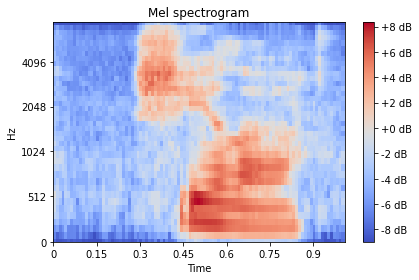

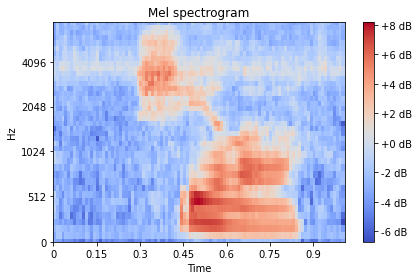

In [8]:

X, target = batch
print("Noisy audio shape",X.shape)
print("Clean audio shape", target[0].shape)
print("Target classid shape", target[1].shape)
print(target[1])
print(noisy_train_loader.dataset.target_class_idx_to_name)

noisy_fbank = test_MelSpectrogram(X)
print("fbank shape", noisy_fbank.shape)
clean_fbank = test_MelSpectrogram(target[0])


index=5
target_class = train_loader.dataset.target_class_idx_to_name[int(target[1][index].numpy())]
print("Target class is", target_class)

test_MelSpectrogram.plot_sample(clean_fbank, index=index)
plt.figure()
test_MelSpectrogram.plot_sample(noisy_fbank, index=index)

soundfile.write('/tmp/clean.wav', target[0][index,0,:].numpy(), 16000)
soundfile.write('/tmp/noisy.wav', X[index,0,:].numpy(), 16000)
IPython.display.display(IPython.display.Audio('/tmp/clean.wav'))
IPython.display.display(IPython.display.Audio('/tmp/noisy.wav'))


torch.mean(noisy_fbank)

# Audio commands classification 
## Get our classifier from last session

**Important**:

We need to **normalize the melspectrogram** to perform well the classification.

For this reason a nn.InstanceNorm2d(1) module is included. [Explanation of instanceNorm: An Overview of Normalization Methods in Deep Learning](http://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/) 

In [9]:
class LeNet(nn.Module):
    def __init__(self, num_classes=31):
        super(LeNet, self).__init__()

        self.features = nn.Sequential(
            nn.InstanceNorm2d(1),
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(3080, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        # x.shape 50x1x40x101

        ## Extract features
        x = self.features(x)

        ## Flatten features
        x = x.view(x.shape[0],-1)
        ## Classify
        x = self.classifier(x)

        return x

Adding a wrapper to LeNet class in order to include two things:
* Now the training data is raw audio, so we need to convert it to melspectrogram
* It is good practice to add a loss function within the class, it makes it later easier to train different modules jointly



In [10]:
class NetWithLoss(nn.Module):
    def __init__(self, classifier, melspectrogram = MelSpectrogram, weight=None):
        super(NetWithLoss, self).__init__()
        self.classifier = classifier
        self.melspectrogram = melspectrogram()
        
        self.loss_function = nn.CrossEntropyLoss(weight=weight)
        
    def forward(self, x):
        # x [50,1,16000]
        x = self.melspectrogram(x) #[50,1,40,101]
        return self.classifier(x)
      
      
    def loss(self, preds, y):
        orig_audio, target_class = y
        return self.loss_function(preds, target_class)
      
    def acc(self, y_pred, y_true):
        y_pred = y_pred.argmax(1)
        orig_audio, y_true = y_true
        acc_pred = ((y_pred == y_true).float()).sum() / len(y_pred)
        return acc_pred * 100
        
      

In [11]:
import torch.nn as nn
import torch.optim as optim
from poutyne.framework import Model
from torchsummary import summary
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

print("Using device", device)
mymodel = NetWithLoss(classifier = LeNet( num_classes = train_loader.dataset.get_n_classes()),
                          weight=None)#train_loader.dataset.get_class_weights())

mymodel.loss(mymodel.forward(batch[0]), batch[1])


print(mymodel.to(device))
summary(mymodel, input_size=(1, 16000))
learning_rate = 0.001

# Optimizer and loss function
optimizer = optim.Adam( filter(lambda p: p.requires_grad, mymodel.parameters()), lr=learning_rate )



model_clean_classifier = Model(mymodel, optimizer, mymodel.loss, batch_metrics=[mymodel.acc])

# Send model on GPU
model_clean_classifier.to(device)

usePretrainedModels=False
if usePretrainedModels:
    model_clean_classifier.load_weights("models/LeNetClassifier")
else:
    model_clean_classifier.fit_generator(train_loader, valid_loader, epochs=4)

 # Test
test_loss, test_acc = model_clean_classifier.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

 # Test
test_loss, test_acc = model_clean_classifier.evaluate_generator(noisy_test_loader)
print('Test with noisy data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Using device cuda:0
NetWithLoss(
  (classifier): LeNet(
    (features): Sequential(
      (0): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=3080, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=12, bias=True)
    )
  )
  (melspectrogram): MelSpectrogram(
    (norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (loss_function): CrossEntropyLoss()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         P

# Enhancing MelSpectrogram with a Denoising Autoencoder

In [12]:
#Helper functions to create a 2D autoencoder borrowed from https://github.com/eveningglow/StarGAN-pytorch/blob/master/model.py
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, k=4, s=2, p=1, norm=True, non_linear='relu'):
        super(ConvBlock, self).__init__()
        layers = []
        layers += [nn.Conv2d(in_dim, out_dim, kernel_size=k, stride=s, padding=p)]
        
        if norm is True:
            layers += [nn.InstanceNorm2d(out_dim, affine=True)]
            
        if non_linear == 'relu':
            layers += [nn.ReLU()]
        elif non_linear == 'leaky_relu':
            layers += [nn.LeakyReLU()]
        elif non_linear == 'tanh':
            layers += [nn.Tanh()]
            
        self.conv_block = nn.Sequential(* layers)
        
    def forward(self, x):
        out = self.conv_block(x)
        return out
        
class ResBlock(nn.Module):
    def __init__(self, in_dim, internal_dim, k=3, s=1, p=1):
        super(ResBlock, self).__init__()
        
        # Use 2 ConvBlock in 1 ResBlock
        conv_block_1 = ConvBlock(in_dim, internal_dim, k=k, s=s, p=p, 
                                 norm=True, non_linear='relu')
        conv_block_2 = ConvBlock(internal_dim, in_dim, k=k, s=s, p=p, 
                                 norm=True, non_linear=None)
        self.res_block = nn.Sequential(conv_block_1, conv_block_2)
    
    def forward(self, x):
        out = x + self.res_block(x)
        return out

#output shape of Transposed convolution
#output_size = strides * (input_size-1) + kernel_size - 2*padding
class DeconvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, k=3, s=1, p=1):
        super(DeconvBlock, self).__init__()
        self.deconv_block = nn.Sequential(
                                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=k, stride=s, padding=p),
                                nn.InstanceNorm2d(out_dim, affine=True),
                                nn.ReLU()
                            )
        
    def forward(self, x):
        out = self.deconv_block(x)
        return out

In [13]:
class DummyAutoEncoder(nn.Module):

    def __init__(self, ):
        super(DummyAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_dim=1, out_dim=32, k=5, s=1, p=2), #maintains input shape and creates 64 channels
            ConvBlock(in_dim=32, out_dim=64, k=4, s=2, p=1)
        )
        self.residuals = nn.Sequential(
            ResBlock(64,64)
        )
        self.decoder = nn.Sequential(
            DeconvBlock(64, 32, k=4, s=2, p=1),
            ConvBlock(in_dim=32, out_dim=1, k=5, s=1, p=2, non_linear='none') #Maintains input shape and combines into 1 channel
        )
        
        self.melspectrogram = MelSpectrogram()
        self.loss_function = nn.L1Loss()
        self.normalize=True
        self.normalization = nn.InstanceNorm2d(1)
        
    def forward(self, x):
        """Forward function encode -> residualbloks -> decode. 
          Note that input x is raw audio and the autoencoder works on the melSpectrogram """
        x = self.melspectrogram(x)
        x = self.encoder(x)
        x = self.residuals(x)
        x = self.decoder(x)
        return x
      
      
    def loss(self, preds, y):
        orig_audio, target_class = y
        orig_fb = self.melspectrogram(orig_audio)
        orig_fb = orig_fb[:,:,:,0:100]
        return self.loss_function(self.normalization(preds), self.normalization(orig_fb))

      
dummy_ae = DummyAutoEncoder()
dummy_ae.eval()
sample = torch.randn(50,1,16000)
output = dummy_ae(sample)
print(output.shape) #<- should be the same as melSpectrogram minus 1, because we are not able to generate uneven sizes [bs,1,40,100]
dummy_ae.loss(dummy_ae.forward(batch[0]), batch[1])

torch.Size([50, 1, 40, 100])


tensor(0.9114, grad_fn=<L1LossBackward>)

In [14]:
mySE = DummyAutoEncoder()



print(mySE.to(device))
summary(mySE, input_size=(1, 16000))
learning_rate = 0.001
# Optimizer
optimizer = optim.Adam( filter(lambda p: p.requires_grad, mySE.parameters()), lr=learning_rate )


model_spectrogram_SE = Model(mySE, optimizer, mySE.loss, batch_metrics=[mySE.loss])

# Send model on GPU
model_spectrogram_SE.to(device)

usePretrainedModels=True
if usePretrainedModels:
    model_spectrogram_SE.load_weights("models/SE.model")
else:
    model_spectrogram_SE.fit_generator(noisy_alldata_loader, noisy_valid_loader, epochs=10)
    model_spectrogram_SE.save_weights("models/mySE.model")



DummyAutoEncoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
      )
    )
  )
  (residuals): Sequential(
    (0): ResBlock(
      (res_block): Sequential(
        (0): ConvBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (conv_block): Sequential(
   

**Testing our speech enhancement model with our previous keyword classifier on noisy and clean data**

The wrapper CleanAndClassifier concatenates our Speech Enhancement with the classifier into a module that we can then pass to poutyne.Model for evaluation on testing data

In [15]:

class CleanAndClassifier(nn.Module):
    def __init__(self, classifier, clean_melspectrogram_from_rawaudio):
        super(CleanAndClassifier, self).__init__()
        self.clean_melspectrogram_from_rawaudio = clean_melspectrogram_from_rawaudio
        self.classifier = classifier
        
    def forward(self, x):
        """x is raw audio with shape [bs,1,16000] """
        
        clean_mel_spectrogram = self.clean_melspectrogram_from_rawaudio(x)
        return self.classifier.classifier(clean_mel_spectrogram)
      
      
    def loss(self, preds, y):
        return self.classifier.loss(preds, y)
      
    def acc(self, y_pred, y_true, ignore_index=-100):
        return self.classifier.acc(y_pred, y_true)
      
composed_module = CleanAndClassifier( model_clean_classifier.network, model_spectrogram_SE.network)  
composed_module.to(device)

optimizer = optim.Adam( filter(lambda p: p.requires_grad, composed_module.parameters()), lr=learning_rate )

eval_SE_model = Model(composed_module, optimizer, composed_module.loss, batch_metrics=[composed_module.acc])      
eval_SE_model.to(device)
 # Test
test_loss, test_acc = eval_SE_model.evaluate_generator(noisy_test_loader)
print('Test with noisy data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

test_loss, test_acc = eval_SE_model.evaluate_generator(test_loader)
print('Test with clean data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))


Test steps: 137 7.53s test_loss: 0.423675 test_acc: 88.397950                                 
Test with noisy data:
	Loss: 0.4236752461089246
	Accuracy: 88.39794976011889
Test steps: 137 5.98s test_loss: 0.296118 test_acc: 91.192389                                 
Test with clean data:
	Loss: 0.29611813249005153
	Accuracy: 91.19238941496798


## Exploratory analysis again....


Noisy audio shape torch.Size([50, 1, 16000])
Clean audio shape torch.Size([50, 1, 16000])
Target classid shape torch.Size([50])
fbank shape torch.Size([50, 1, 40, 101])
Filtered spectrogram shape torch.Size([50, 1, 40, 100]) Original spectrogram shape torch.Size([50, 1, 40, 101]) Noisy spectrogram shape torch.Size([50, 1, 40, 101])
LeNet predictions tensor([ 0,  0,  2,  0,  0,  0,  0,  3,  0, 10,  0,  4,  0,  0,  0,  3,  0,  0,
        10,  0,  0,  0,  0,  0,  0,  5,  4,  0,  0,  1,  0, 10,  0,  6,  3,  8,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
       device='cuda:0')
Composed model predictions tensor([ 0,  0,  2,  0,  0,  0,  0,  3,  0, 10,  0,  4,  0,  0,  0,  3,  0,  0,
        10,  0,  0,  0,  0,  0,  0,  5,  4,  0,  0,  1,  0, 10,  0,  6,  0,  8,
         0,  0,  0,  0,  0,  1,  0,  6,  0,  9,  0,  0,  0,  0],
       device='cuda:0')
Labels tensor([ 0,  0,  2,  0, 10,  0,  0,  3,  0, 10,  0,  4,  0,  0,  0,  3,  0,  0,
        10,  0,  0,  0,  0,  0,  0, 

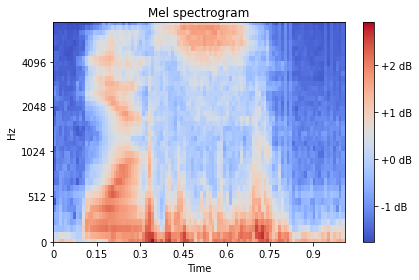

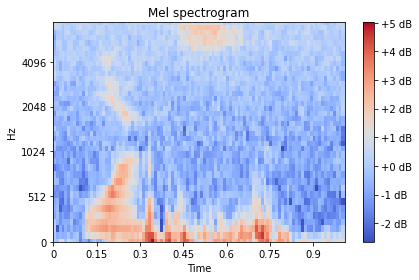

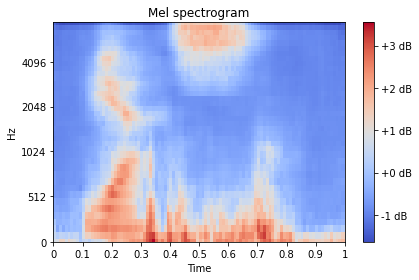

In [16]:


X, target = batch
print("Noisy audio shape",X.shape)
print("Clean audio shape", target[0].shape)
print("Target classid shape", target[1].shape)


myspec = model_spectrogram_SE.network(X.cuda())
myspec=myspec.cpu()

noisy_fbank = test_MelSpectrogram(X)
print("fbank shape", noisy_fbank.shape)
clean_fbank = test_MelSpectrogram(target[0])
index=2

test_norm = nn.InstanceNorm2d(1)

clean_fbank = test_norm(clean_fbank)
noisy_fbank = test_norm(noisy_fbank)
myspec  = test_norm(myspec.detach())



test_MelSpectrogram.plot_sample(clean_fbank, index=index)
plt.figure()
test_MelSpectrogram.plot_sample(noisy_fbank, index=index)

plt.figure()
test_MelSpectrogram.plot_sample(myspec, index=index)

print("Filtered spectrogram shape", myspec.shape, "Original spectrogram shape", clean_fbank.shape,"Noisy spectrogram shape", noisy_fbank.shape)

#preds = mymodel.network((clean_fbank.to(device)))
#preds = composed_module.classifier.network(composed_module.input_norm(clean_fbank.to(device)))
preds = composed_module(X.cuda())
y_pred = preds.argmax(1)
print("LeNet predictions" , y_pred)
preds  = mymodel(X.cuda())
y_pred = preds.argmax(1)
print("Composed model predictions", y_pred)
print("Labels", batch[1][1])

# TASK 1: Train Speech Enhancement and keywords classifier jointly end-to-end

Modify CleanAndClassifier.loss() to add the reconstruction loss term of clean_melspectrogram_from_rawaudio

Then train eval_SE_model on noisy_training data for one epoch

In [17]:
class CleanAndClassifier(nn.Module):
    def __init__(self, classifier, clean_melspectrogram_from_rawaudio):
        super(CleanAndClassifier, self).__init__()
        self.clean_melspectrogram_from_rawaudio = clean_melspectrogram_from_rawaudio
        self.classifier = classifier
        
    def forward(self, x):
        """x is raw audio with shape [bs,1,16000] """
        
        clean_mel_spectrogram = self.clean_melspectrogram_from_rawaudio(x)
        return [clean_mel_spectrogram, self.classifier.classifier(clean_mel_spectrogram)]
      
      
    def loss(self, preds, y):
        #************************************************#
        #TASK 1
        #Write a loss that combines self.classifier.loss(,y) 
        #and self.clean_melspectrogram_from_rawaudio.loss(,y)
        #************************************************#
        pred_melspec, pred_y = preds #recover spectrogram and classifier output
        reconstruction_loss = self.clean_melspectrogram_from_rawaudio.loss(pred_melspec,y)
        classification_loss = self.classifier.loss(pred_y,y)
        total_loss = reconstruction_loss + classification_loss
        return total_loss
      
    def acc(self, preds, y_true):
        _, y_pred = preds
        return self.classifier.acc(y_pred, y_true)
      
composed_module = CleanAndClassifier( model_clean_classifier.network, model_spectrogram_SE.network)  
composed_module.to(device)

optimizer = optim.Adam( filter(lambda p: p.requires_grad, composed_module.parameters()), lr=learning_rate )

eval_SE_model = Model(composed_module, optimizer, composed_module.loss, batch_metrics=[composed_module.acc])      
eval_SE_model.to(device)

eval_SE_model.fit_generator(noisy_train_loader, noisy_valid_loader, epochs=2)

 # Test
test_loss, test_acc = eval_SE_model.evaluate_generator(noisy_test_loader)
print('Test with noisy data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

test_loss, test_acc = eval_SE_model.evaluate_generator(test_loader)
print('Test with clean data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch: 1/2 Train steps: 1059 Val steps: 136 117.30s loss: 0.489899 acc: 92.993123 val_loss: 0.569770 val_acc: 90.467783
Epoch: 2/2 Train steps: 1059 Val steps: 136 116.96s loss: 0.438532 acc: 94.630578 val_loss: 0.572402 val_acc: 91.041480
Test steps: 137 7.59s test_loss: 0.567822 test_acc: 91.543523                                 
Test with noisy data:
	Loss: 0.5678216292200597
	Accuracy: 91.54352345218952
Test steps: 137 6.15s test_loss: 0.388790 test_acc: 93.094365                                 
Test with clean data:
	Loss: 0.388789577953294
	Accuracy: 93.09436493366411


# Task 2: Unsupervised Speech Enhancement on Raw Audio

In [18]:
class ConvBlock1d(nn.Module):
    def __init__(self, in_dim, out_dim, k=4, s=2, p=1, norm=True, non_linear='relu'):
        super(ConvBlock1d, self).__init__()
        layers = []
        layers += [nn.Conv1d(in_dim, out_dim, kernel_size=k, stride=s, padding=p)]
        
        if norm is True:
            layers += [nn.InstanceNorm1d(out_dim, affine=True)]
            
        if non_linear == 'relu':
            layers += [nn.ReLU()]
        elif non_linear == 'leaky_relu':
            layers += [nn.LeakyReLU()]
        elif non_linear == 'tanh':
            layers += [nn.Tanh()]
            
        self.conv_block = nn.Sequential(* layers)
        
    def forward(self, x):
        out = self.conv_block(x)
        return out
        
class ResBlock1d(nn.Module):
    def __init__(self, in_dim, internal_dim, k=3, s=1, p=1):
        super(ResBlock1d, self).__init__()
        
        # Use 2 ConvBlock in 1 ResBlock
        conv_block_1 = ConvBlock1d(in_dim, internal_dim, k=k, s=s, p=p, 
                                 norm=True, non_linear='relu')
        conv_block_2 = ConvBlock1d(internal_dim, in_dim, k=k, s=s, p=p, 
                                 norm=True, non_linear=None)
        self.res_block = nn.Sequential(conv_block_1, conv_block_2)
    
    def forward(self, x):
        out = x + self.res_block(x)
        return out
    
class DeconvBlock1d(nn.Module):
    def __init__(self, in_dim, out_dim, k=3, s=1, p=1):
        super(DeconvBlock1d, self).__init__()
        self.deconv_block = nn.Sequential(
                                nn.ConvTranspose1d(in_dim, out_dim, kernel_size=k, stride=s, padding=p),
                                nn.InstanceNorm1d(out_dim, affine=True),
                                nn.ReLU()
                            )
        
    def forward(self, x):
        out = self.deconv_block(x)
        return out

## Task 2: write forward function

 with skip connections between ConvBlocks in enconder and corresponding DeconvBlock in decoder

In [19]:
class DummyRawAudioAutoEncoder(nn.Module):

    def __init__(self, ):
        super(DummyRawAudioAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            #bs, 1, 16000
            ConvBlock1d(in_dim=1, out_dim=64, k=7, s=1, p=3), #maintains input shape and creates 64 channels bs, 1, 16000
            #bs, 64, 16000
            ConvBlock1d(in_dim=64, out_dim=96, k=4, s=2, p=1),#half dimension 
            #bs, 96, 8000
            ConvBlock1d(in_dim=96, out_dim=128, k=4, s=2, p=1),
            #bs, 128, 4000
            ConvBlock1d(in_dim=128, out_dim=192, k=4, s=2, p=1),
            #bs, 192, 2000
            ConvBlock1d(in_dim=192, out_dim=256, k=4, s=2, p=1),
            #bs, 256, 1000
            ConvBlock1d(in_dim=256, out_dim=256, k=4, s=2, p=1),
            #bs, 256, 500
        )
        
        self.residuals = nn.Sequential(
            ResBlock1d(256,256),
            ResBlock1d(256,256),
            ResBlock1d(256,256)
        )
        self.decoder = nn.Sequential(
            DeconvBlock1d(256, 256, k=4, s=2, p=1),
            DeconvBlock1d(256, 192, k=4, s=2, p=1),
            DeconvBlock1d(192, 128, k=4, s=2, p=1),
            DeconvBlock1d(128, 96, k=4, s=2, p=1),
            DeconvBlock1d(96, 64, k=4, s=2, p=1),
            ConvBlock1d(in_dim=64, out_dim=1, k=7, s=1, p=3, non_linear='none') #Maintains input shape and combines into 1 channel
            #bs, 1, 16000
        )
        
        
        self.melspectrogram = MelSpectrogram()
        self.loss_function = nn.L1Loss()
        self.normalize=True
        self.normalization = nn.InstanceNorm2d(1)
        
    def forward(self, x):
        """
       +------------------------------+            +-----------------------------+          +----------------------------+
       |                              |            |                             |          |                            |
       |    Encoder                   |            |    ResBlocks                |          |  Decoder                   |
       |                              |            |                             |          |                            |
       |                              |            |                             |          |                            |
       |   +----+   +----+   +----+   |            |                             |          |   +----+   +----+   +----+ |
       |   |    |   |    |   |    |   |            |                             |          |   |    |   |    |   |    | |
       |   |    +-+-+    +-+-+    +-+--------------+                             +------------+-+    +-+-+    +-+-+    | |
       |   +----+ | +----+ | +----+ | |            |                             |          | | +----+ | +----+ | +----+ |
       |          |        |        | |            |                             |          | |        |        |        |
       |          |        |        | |            |                             |          | |        |        |        |
       |          |        |        | |            |                             |          | |        |        |        |
       |          |        |        | |            |                             |          | |        |        |        |
       +------------------------------+            +-----------------------------+          +----------------------------+
                  |        |        |---------------------------------------------------------|        |        |
                  |        +---------------------------------------------------------------------------+        |
                  +---------------------------------------------------------------------------------------------++
                                                        Skip connections
                                                       Ouputs from Encoder
                                                       should be added to the inputs
                                                       of the Decoder

        """
        # hint:
        # x = self.encoder(x) 
        # is equivalent to:
        #for e in self.encoder:
        #    x = e(x)

        encoder_outputs = []
        for e in self.encoder:
            x = e(x)
            encoder_outputs.append(x)

        x = self.residuals(x)

        encoder_outputs.reverse()

        for i,d in enumerate(self.decoder):
            x = d(x+encoder_outputs[i])

        return x
      
      
    def loss(self, pred_audio, y):
        orig_audio, target_class = y
        orig_fb = self.melspectrogram(orig_audio)
        pred_fb = self.melspectrogram(pred_audio)
        return self.loss_function(self.normalization(pred_fb), self.normalization(orig_fb))
      


sample = torch.randn(50,1,16000)
dummy_ae = DummyRawAudioAutoEncoder()
dummy_ae.eval()
dummy_ae(sample)
dummy_ae = None

In [20]:

myrawSE = DummyRawAudioAutoEncoder()

print(myrawSE.to(device))
    
summary(myrawSE, input_size=(1, 16000))

learning_rate = 0.001
# # # Optimizer
optimizer = optim.Adam( filter(lambda p: p.requires_grad, myrawSE.parameters()), lr=learning_rate )


model_sraw_SE = Model(myrawSE, optimizer, myrawSE.loss, batch_metrics=[myrawSE.loss])

# # # Send model on GPU
model_sraw_SE.to(device)

usePretrainedModels=True
if usePretrainedModels:
    model_sraw_SE.load_weights("models/RawSE.model")
else:
    model_sraw_SE.fit_generator(noisy_alldata_loader, noisy_valid_loader, epochs=10)


DummyRawAudioAutoEncoder(
  (encoder): Sequential(
    (0): ConvBlock1d(
      (conv_block): Sequential(
        (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
      )
    )
    (1): ConvBlock1d(
      (conv_block): Sequential(
        (0): Conv1d(64, 96, kernel_size=(4,), stride=(2,), padding=(1,))
        (1): InstanceNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
      )
    )
    (2): ConvBlock1d(
      (conv_block): Sequential(
        (0): Conv1d(96, 128, kernel_size=(4,), stride=(2,), padding=(1,))
        (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
      )
    )
    (3): ConvBlock1d(
      (conv_block): Sequential(
        (0): Conv1d(128, 192, kernel_size=(4,), stride=(2,), padding=(1,))
        (1): InstanceNorm1d(192, eps=1e-05, m

## [Juan Diego]

## Hypothesis

¿Will the raw audio files 1D have the same performance for noise cleaning and classifer compared to melSpectrogram 2d audio files?

## Consluions
It can be seen the acc. for noisy data is 25.2% and the acc. for clean data is 10.4% when training a U-NET on raw 1D signal for audio cleaning on top of the classifier. 

Clearly, it contrasts with the acc. got for same task (audio noise cleaning on top of the classifier) but dealing with melSpectrogram 2D audio files where the acc. was 88% and 91% respectively.

This difference of performance, can be seen as melSpectrogram 2D works better for Autoencoder architecure, as more information can go through in comparison with 1D data.

The clear evidence, can be find on the architecures used. For melSpectorgram was used a RES-NET vs U-NET for raw .wav 1D files.

Training end-to-end, for cleaning noise + classifer for raw 1D data, will not achieve the acc. of equivalent in melSpectorgram (recall the performance was improved around 10%).



In [21]:
# [Juan Diego] U-net for signal (1D) audio classification
model_sraw_SE.fit_generator(noisy_alldata_loader, noisy_valid_loader, epochs=2)
model_sraw_SE.save_weights("models/RawSE2.model")

test_loss, test_acc = model_sraw_SE.evaluate_generator(noisy_test_loader)

print('Test with noisy data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

test_loss, test_acc = model_sraw_SE.evaluate_generator(test_loader)
print('Test with clean data:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch: 1/2 Train steps: 1295 Val steps: 136 1084.99s loss: 0.254651 loss: 0.254651 val_loss: 0.246578 val_loss: 0.246578
Epoch: 2/2 Train steps: 1295 Val steps: 136 1075.94s loss: 0.252921 loss: 0.252921 val_loss: 0.242713 val_loss: 0.242713
Test steps: 137 42.41s test_loss: 0.252079 test_loss: 0.252079                                
Test with noisy data:
	Loss: 0.2520791968465636
	Accuracy: 0.2520791968465636
Test steps: 137 42.32s test_loss: 0.104685 test_loss: 0.104685                                
Test with clean data:
	Loss: 0.10468466460552195
	Accuracy: 0.10468466460552195


Noisy audio shape torch.Size([50, 1, 16000])
Clean audio shape torch.Size([50, 1, 16000])
Target classid shape torch.Size([50])
fbank shape torch.Size([50, 1, 40, 101])


Text(0.5, 1.0, 'Cleaned')

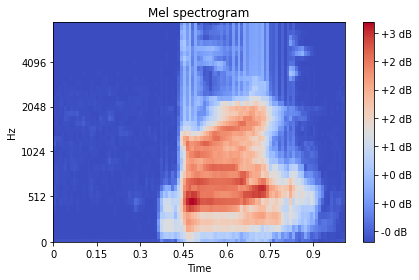

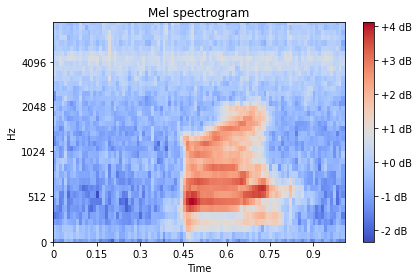

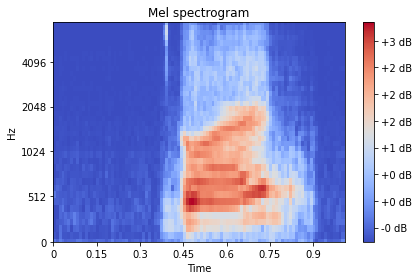

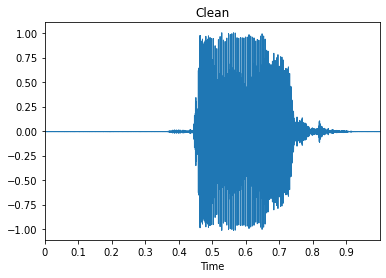

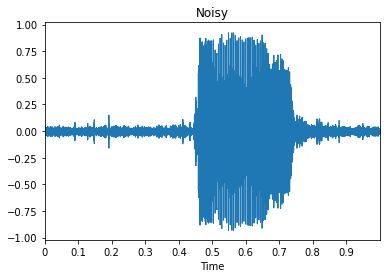

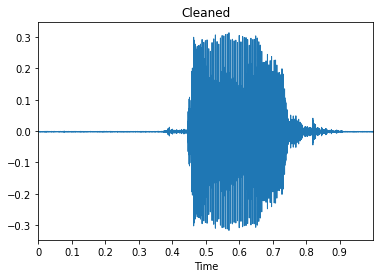

In [32]:
#model_sraw_SE.save_weights("models/RawSEsmall.model")
#batch = next(noisy_train_loader)
for batch in noisy_train_loader:
    break
X, target = batch
print("Noisy audio shape",X.shape)
print("Clean audio shape", target[0].shape)
print("Target classid shape", target[1].shape)


cleaned_audio = model_sraw_SE.network(X.cuda())
cleaned_audio = cleaned_audio.cpu().detach()
cleaned_fbank = test_MelSpectrogram(cleaned_audio)
index=5

noisy_fbank = test_MelSpectrogram(X)
print("fbank shape", noisy_fbank.shape)
clean_fbank = test_MelSpectrogram(target[0])


soundfile.write('/tmp/clean.wav', target[0][index,0,:].numpy(), 16000)
soundfile.write('/tmp/noisy.wav', X[index,0,:].numpy(), 16000)
soundfile.write('/tmp/cleaned.wav', cleaned_audio[index,0,:].numpy()*3.0, 16000)
IPython.display.display(IPython.display.Audio('/tmp/clean.wav'))
IPython.display.display(IPython.display.Audio('/tmp/noisy.wav'))
IPython.display.display(IPython.display.Audio('/tmp/cleaned.wav'))



test_norm = nn.InstanceNorm2d(1)

clean_fbank = test_norm(clean_fbank)
noisy_fbank = test_norm(noisy_fbank)
cleaned_fbank  = test_norm(cleaned_fbank)


plt.figure()
test_MelSpectrogram.plot_sample(clean_fbank, index=index)
plt.figure()
test_MelSpectrogram.plot_sample(noisy_fbank, index=index)

plt.figure()
test_MelSpectrogram.plot_sample(cleaned_fbank, index=index)


plt.figure()
librosa.display.waveplot(target[0][index,0,:].numpy(), sr=16000)
plt.title('Clean')
plt.figure()
librosa.display.waveplot(X[index,0,:].numpy(), sr=16000)
plt.title('Noisy')
plt.figure()
librosa.display.waveplot(cleaned_audio[index,0,:].numpy(), sr=16000)
plt.title('Cleaned')
